## This is a demo to separate the sound of code spawning from backgrounds
Here the background sounds might be from wave, ships, cruises, noise, etc.


In [1]:
# built-in libs and packages 
# import wave
import os
from os import listdir
from os.path import isfile, join

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd 
import math
import librosa
import librosa.display
import seaborn as sns

In [2]:
ls /home/deep/deep/data/codsounds/spawnseis_pilot

20180305_180000.TextGrid*             20180306_001316_ch2.wav*
20180305_180000_ch1.wav*              20180306_031955.TextGrid*
20180305_180000_ch1filt.wav           20180306_031955.wav*
20180305_180000_ch1filtres.wav        20180306_031955_ch1.wav*
20180305_180000_gruntint.csv          20180306_031955_ch2.wav*
20180305_180000_onlygrunts.TextGrid*  20180306_062633.TextGrid*
20180306_001316.TextGrid*             20180306_062633.wav*
20180306_001316.wav*                  20180306_062633_ch1.wav*
20180306_001316_ch1.wav*              20180306_062633_ch2.wav*


## 1. Read the audio data and the labels of cod spawn grunts
1) Read the audio data and annotation of spwan grunts

2) Resample the data

In [70]:
# paths and files = ""
filepath = "/home/deep/deep/data/codsounds/spawnseis_pilot"

allfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
# [print(ifile) for ifile in allfiles]

filename = "20180305_180000_ch1.wav"
# annotatecsv = "20180306_062633.TextGrid"
annotatecsv = '20180305_180000_gruntint.csv'

file2read = os.path.join(filepath, filename)
label2read = os.path.join(filepath, annotatecsv)
# check the exist of file and maybe also the quality
if not file2read:
    print("File doesn't exist")
if not label2read:
    print("Annotation file not found")


sample_rate, samples = wavfile.read(file2read)
samples = samples.astype(float)
print("Sample rate {} | Audio size {}".format(sample_rate, samples.shape))

times_sounds = pd.read_csv(label2read, header=0)
# labels = [[e]]
print('\n', '*'*50, '\n', times_sounds.head())
times_sounds.drop('text', axis=1, inplace=True)
print('\n', '*'*50, '\n', times_sounds.head())




FileNotFoundError: [Errno 2] No such file or directory: '/home/deep/deep/data/codsounds/spawnseis_pilot/20180305_180000_ch2.wav'

Perform Fast Fourier transformation on the Audio file

In [60]:

import IPython.display as ipd
index_grunt = np.arange(1900000,2200000, 1) # label 1
# index_grunt = np.arange(1960000,2260000, 1) # label 2
# index_grunt = np.arange(8600000,8900000, 1) # label 3 - one skeptic grunt sound afterwards
# index_grunt = np.arange(9504000,9804000, 1) # label 4 
index_grunt = np.arange(21216000,21516000, 1) # label 5 

# index_grunt = np.arange(1900000,21516000, 1) # first 5 grunts 

# index_noise = np.arange(2020000,2100000, 1)
ipd.Audio(samples[index_grunt], rate = sample_rate) # load a local WAV file

214879.7243170914
(300000,) (300000,)


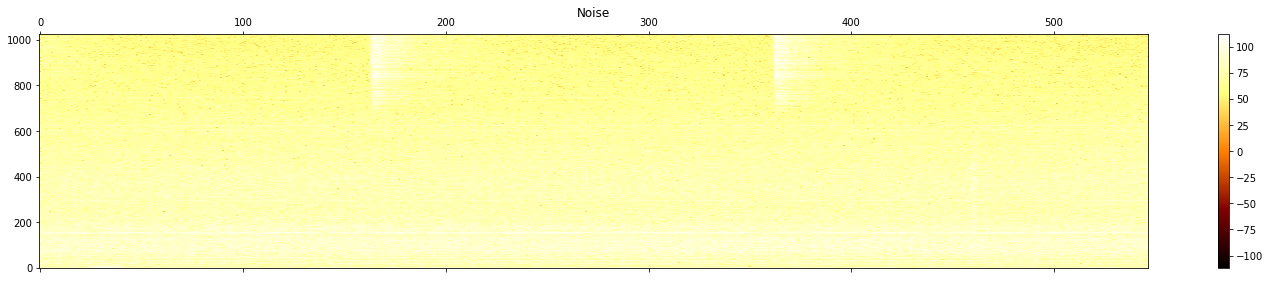

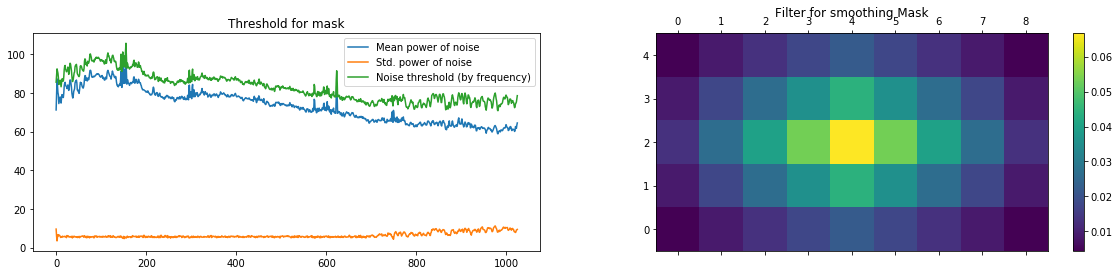

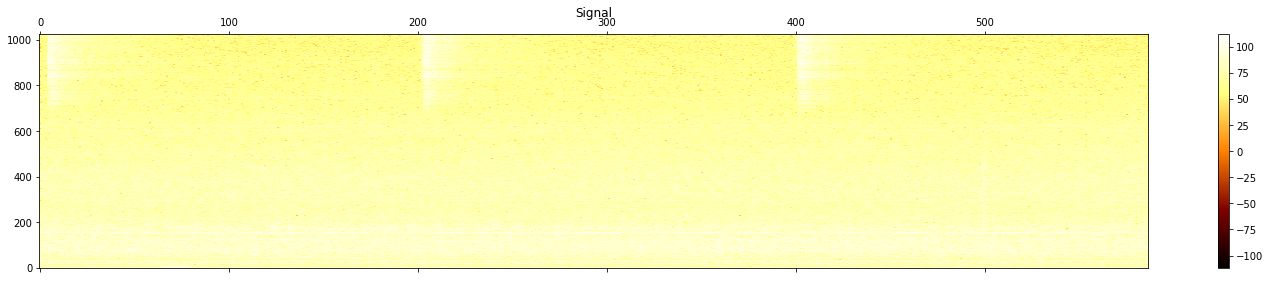

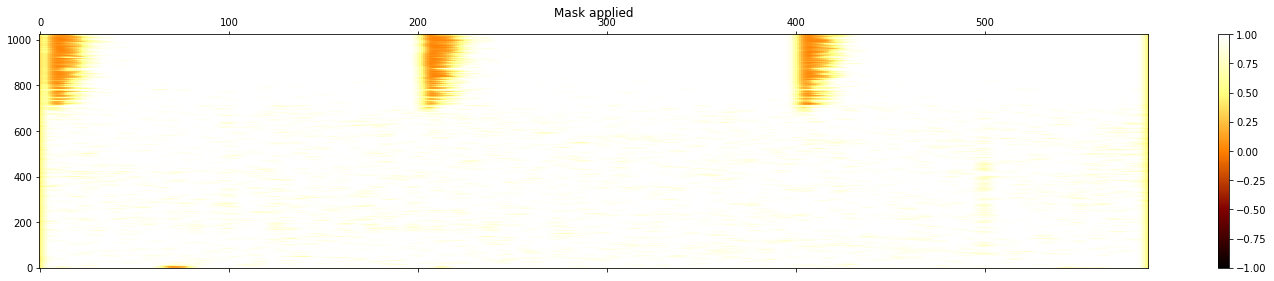

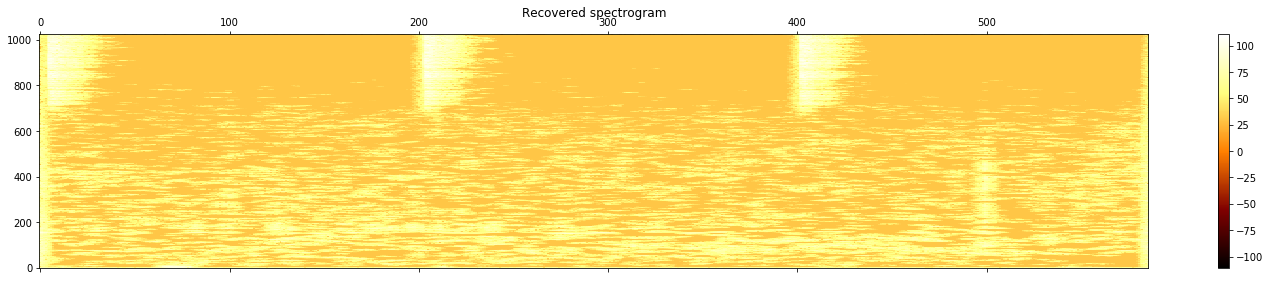

In [67]:
%matplotlib inline
# Calculate the FFT of the samples
from scipy.fftpack import fft, ifft
fft_out = fft(samples[index_grunt])


# plt.subplots(1,1, figsize=(10, 8))
# plt.plot(samples[1970000:2100000], np.abs(fft_out), '-*')
# plt.show()


# from librosa import display
# plt.figure()
# librosa.display.waveplot(y=samples[1970000:2100000], sr = sample_rate)


# Get the mean value and calculate a threshold
mean_value = np.mean(abs(fft_out))
print(mean_value)
threshold  = 0.5 * mean_value; #  Fine-tune this, the larger value the stronger filter

# Remove everything that's below the threshold (we assume that it corresponds to noise)
fft_out[abs(fft_out) < threshold] = 0


threshold  = 1.9 * mean_value; #  Fine-tune this, the larger value the stronger filter
fft_out[abs(fft_out) > threshold] = 0

# Get the filtered samples
filtered_samples = ifft(fft_out)
print(filtered_samples.shape, samples[index_grunt].shape)


##### use noisereduce to filter
import noisereduce as nr
reduced_noise = nr.reduce_noise(audio_clip=samples[index_grunt], 
                                noise_clip=samples[index_grunt[20000:]],
                                verbose=True)

# reduced_noise = nr.reduce_noise(audio_clip=filtered_samples.astype(float), 
#                                 noise_clip=filtered_samples[50000:2100000].astype(float),
#                                 verbose=True)


In [63]:
# Manual denoised results

import IPython.display as ipd
ipd.Audio(filtered_samples, rate = sample_rate) # load a local WAV file

In [64]:
# Denoised results by noisereduce
import IPython.display as ipd
ipd.Audio(reduced_noise, rate = sample_rate) # load a local WAV file

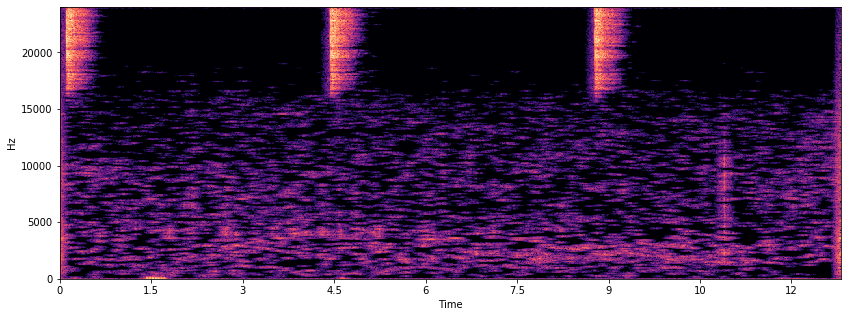

In [65]:
%matplotlib inline
# # Original samples
# X = librosa.stft(samples[index_grunt].astype(float))
# Xdb = librosa.amplitude_to_db(abs(X))
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(Xdb, sr=sample_rate_flt, x_axis='time', y_axis='hz')

# # Manually filtered samples
# X = librosa.stft(filtered_samples.astype(float))
# Xdb = librosa.amplitude_to_db(abs(X))
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(Xdb, sr=sample_rate_flt, x_axis='time', y_axis='hz')

# Denoised samples by noisereduce
X = librosa.stft(reduced_noise.astype(float), n_fft = 2048, win_length=1000)
Xdb = librosa.amplitude_to_db(abs(X))
fig = plt.figure(figsize=(14, 5))
# librosa.display.specshow(Xdb, sr=sample_rate_flt, x_axis='time', y_axis='hz')
data_axes = librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz') # hz log
# librosa.feature.melspectrogram(y = np.transpose(Xdb), sr=sample_rate_flt,x_axis='time', y_axis='hz')

(1025, 1201)


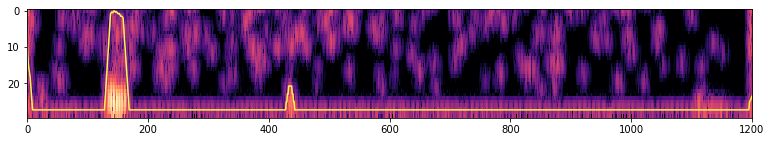

In [69]:
%matplotlib inline
# method 1
# spectrogram= librosa.feature.melspectrogram(
#     y=reduced_noise.astype(float), sr=sample_rate, window='hann',  
#     center=True, pad_mode='reflect', power=2.0)

# method 2
spectrogram = librosa.core.reassigned_spectrogram(
    reduced_noise.astype(float), sr=sample_rate, 
    S=None, n_fft=2048, hop_length=None, win_length=None, 
    window='hann', center=True, reassign_frequencies=True, 
    reassign_times=True, ref_power=1e-06, fill_nan=False, 
    clip=True, pad_mode='reflect')

print(Xdb.shape)
plt.figure(figsize=(13, 2))
plt.imshow(np.flipud(Xdb[0:30, ]), cmap = 'magma',aspect='auto', interpolation='nearest')


from skimage.morphology import disk
from skimage.filters import rank




# prof1 = np.array([np.math.exp(e) for e in prof1])
prof1 = Xdb[1:15,:].mean(0)


val_max = max(prof1)
prof1[prof1<65]=0

prof1_sm = np.empty(prof1.shape)
for i in range(0, len(prof1)):
    prof1_sm[i] = np.mean(prof1[max(0, i-5):min(i+5, len(prof1))])

plt.plot((prof1_sm.max() - prof1_sm)/3, color=[1,0.96,0.3])


(1025, 1201)


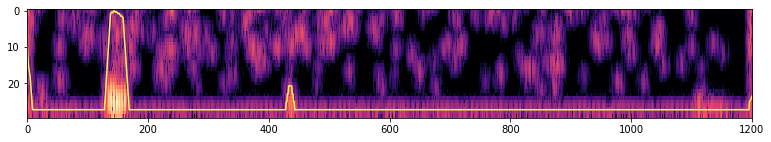

In [66]:
%matplotlib inline
# method 1
# spectrogram= librosa.feature.melspectrogram(
#     y=reduced_noise.astype(float), sr=sample_rate, window='hann',  
#     center=True, pad_mode='reflect', power=2.0)

# method 2
spectrogram = librosa.core.reassigned_spectrogram(
    reduced_noise.astype(float), sr=sample_rate, 
    S=None, n_fft=2048, hop_length=None, win_length=None, 
    window='hann', center=True, reassign_frequencies=True, 
    reassign_times=True, ref_power=1e-06, fill_nan=False, 
    clip=True, pad_mode='reflect')

print(Xdb.shape)
plt.figure(figsize=(13, 2))
plt.imshow(np.flipud(Xdb[0:30, ]), cmap = 'magma',aspect='auto', interpolation='nearest')


from skimage.morphology import disk
from skimage.filters import rank




# prof1 = np.array([np.math.exp(e) for e in prof1])
prof1 = Xdb[1:15,:].mean(0)


val_max = max(prof1)
prof1[prof1<65]=0

prof1_sm = np.empty(prof1.shape)
for i in range(0, len(prof1)):
    prof1_sm[i] = np.mean(prof1[max(0, i-5):min(i+5, len(prof1))])

plt.plot((prof1_sm.max() - prof1_sm)/3, color=[1,0.96,0.3])


In [35]:
Xdb.max()

107.70077

In [ ]:
# sound_filtered = call(sounds, "Filter (pass Hann band)", 0.0, 600.0, 10.0)

file2read_flt = file2read[:-4] + "filt.wav"
sample_rate_flt, samples_flt = wavfile.read(file2read_flt)
# sound_filtered.save(file2read_flt, "WAV")

# sample_rate_flt, samples_flt = wavfile.read(file2read_flt, )


# print("Sample_flt rate {} | Audio size {}".format(sample_rate_flt, samples_flt.shape))

In [ ]:
0.25/4.5*200000


In [ ]:
print(samples.shape, samples_flt.shape)

In [ ]:



# # Filter sound with praat using parselmouth
# import parselmouth
# from parselmouth.praat import call

# sounds = parselmouth.Sound(file2read)
# sound_resampled = call(sounds, "Resample", 1200, 50)
# type(sound_resampled)

# file2read_flt_res = file2read_flt[:-4] + "res.wav"

# sound_resampled.save(file2read_flt_res, "WAV")

In [ ]:
samples_flt

In [ ]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

In [ ]:

# Filter sound with praat using parselmouth
import parselmouth
from parselmouth.praat import call

sounds = parselmouth.Sound(file2read)

intensity = sounds.to_intensity()
# print(type(ss.))

In [ ]:
spectrogram = sounds.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

In [ ]:
sound_filtered = call(sounds, "Filter (pass Hann band)", 0.0, 600.0, 10.0)

file2read_flt = file2read[:-4] + "filt.wav"
sound_filtered.save(file2read_flt, "WAV")

In [ ]:
sound_resampled = call(sound_filtered, "Resample", 1200, 50)
type(sound_resampled)

file2read_flt_res = file2read_flt[:-4] + "res.wav"

sound_resampled.save(file2read_flt_res, "WAV")

In [ ]:
# Reload the data
sample_rate, samples = wavfile.read(file2read_flt_res)
samples = samples.astype(float)
print(samples.shape)

Now, play the audio. Try with a earphone with base, you may here a low frequency signal near 35 seconds

In [ ]:
import IPython.display as ipd
ipd.Audio(samples[1670000:1730000], rate = sample_rate/1000) # load a local WAV file

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(samples[1600000:1800000], sr=sample_rate)

If not working, try this song to relax

In [ ]:
import IPython.display as ipd
ipd.Audio('My dream.mp3') # load a local WAV file

In [ ]:
times_sounds_fs = times_sounds * sample_rate
times_sounds_fsr = times_sounds_fs.applymap(math.ceil)
print('*'*30, '\n Converted time labels \n', times_sounds_fsr.head())

labels = times_sounds_fsr.values
print('*'*30, '\n Labels array \n', labels[0:5])

In [ ]:
import librosa
import librosa.display

x = samples[1600000:1800000]
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')

# plt.figure(figsize=(14, 5))
# librosa.display.waveplot(samples.), sr=sample_rate)

In [ ]:
# %matplotlib inline
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sample_rate)

In [ ]:
samples

In [ ]:
%matplotlib notebook

X = np.arange(0,70,0.5)+20
X = X #+ np.random.randn(len(X))*0.3
Y = np.reshape([np.sin(X), np.cos(X)], (-1, len(X)))
Labels = np.array([[10, 15], [29, 33], [40, 48], [50, 66]])
# print(x, '\n', y)


def get_subsample(y, ratio):
    if len(y)>1000000:
        ind = np.arange(0, len(y), int(len(y)*ratio))
        y = y[ind]
    else:
        ind=np.arange(0, len(y))
    
    return ind, y

def plot_sounds(y,  x=[], labels=[]):
    
    # two channels to show separately
    fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
    i = 1 # channel flag
#     for ax, y in zip( axs, Y):
#         print()
    ratio = 0.00001
    ind, y = get_subsample(y, ratio)

    # Plot curves
    if any(x):
        x = x[ind]
        ax.plot(x, y)
    else:
        ax.plot(y)
#     ax.axes.set_title('Channel %d ' % i)
    i+=1

    # Plot labels with filled rectanles
    ymin, ymax = np.min(y), np.max(y)
    ymin, ymax  = ymin - (ymax - ymin)*0.05, ymax + (ymax - ymin)*0.05


    if any(labels):
        # create a Rectangle patch
        for lab in Labels:
            h = ymax - ymin
            w = lab[1] - lab[0] +1


            rect = plt.Rectangle((lab[0],ymin),h,w,
                                    linewidth=1, edgecolor='r',
                                    facecolor='green',alpha=0.5)           
            ax.add_patch(rect)

# plot_sounds(Y[0,:], X, labels)
# plot_sounds(Y[1,:], X, labels)


In [ ]:
plot_sounds(np.transpose(samples[0:200,0]))

In [ ]:
samples.shape

In [ ]:
# functions to read the data or DataLoader

frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)



In [ ]:
# Parameters to train CNN
EPOCHE = 1           # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50      # 
LR = 0.001           # learning rate

In [ ]:
# CNN to 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(      # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,           # input height(bands/ colors)
                out_channels=16,         # n_filters
                kernel_size=(55,1),           # filter size (squre or (5,3) for ex. )
                stride=1,                # filter movement/step
                padding=27,               # if want some width and length of this image after Conv2d,
                                         #  padding = (kernel_size-1)/2 if stride=1     
            ),
            nn.ReLU(),                   # activation
            nn.MaxPool1d(kernel_size=9), # choose max value in 2x2 area, output shape(16, 14, 14)            
        )
        
        
        self.conv2 = nn.Sequential(      # input shape(16, 14, 14)
            nn.Conv2d(16, 32, 55, 1, 27),  # output shape(32,14, 14)
            nn.ReLU(),                   # activation
            nn.MaxPool1d(9),             # output shape(32, 7, 7) 
        )
        self.out = nn.Linear(32 * 7 * 7, 10) # fully connected layer, output 10 classes
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12,64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(), # compress to a range (0,1)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)        # flatten the output fo conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x  # return x for visualization
    
cnn = CNN()
print(cnn) # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                      # the target label is not one-hotted